In [14]:
import torch
import numpy as np
from torch.distributions import Normal, Uniform
import sys
import math
import multiprocessing as mp
from joblib import Parallel, delayed
import time

In [25]:
def f():
    z1 = Normal(0,1).sample()
    z2 = R1(z1)
    # the following is used to avoid tail recursion  - simple solution and stops stack overflow 
    # You can not use this trick straight forwardly if you wish to access multiple core / threads. 
    while z2 == math.inf:
#         print(' while loop triggered')
        z2 = R1(z1)
    z3 = Uniform(0,2).sample()
    z4 = R2(z2,z3)
    return torch.tensor([z1,z2,z3,z4])

def R1(z1, i=0):
    temp = Normal(z1,1).sample()
    if temp.data > 0:
        return temp
    elif i == 1000:
        return math.inf
    else:
        i = i+1
        return R1(z1,i)

def R2(z2,z3):
    ''' Need to ensure that we don't return a 
    value generated from a deterministic process, i.e if return temp=0, that
    has not been generated from the while loop - although with R1 defined as it is 
    this will never be the case'''
    temp = 0
    while temp < z2:
        temp = Normal(z3,1).sample()
    return temp



# # could write as list comprehension
# num_cores = mp.cpu_count()

# results = Parallel(n_jobs=num_cores)(delayed(f)() for i in range(n_samples))
# print(results)


In [ ]:
n_samples = 100000
samples_1 = torch.zeros(n_samples,4)
samples_2 = torch.zeros(n_samples,4)
samples_3 =torch.zeros(n_samples,4)
samples_4 = torch.zeros(n_samples,4)
samples_5 = torch.zeros(n_samples,4)
samples_6 = torch.zeros(n_samples,4)
samples_7 = torch.zeros(n_samples,4)
samples_8 = torch.zeros(n_samples,4)
samples_9 = torch.zeros(n_samples,4)
samples_10 = torch.zeros(n_samples,4)

# # could write as list comprehension
# num_cores = mp.cpu_count()

# results = Parallel(n_jobs=num_cores)(delayed(f)() for i in range(n_samples))
# print(results)
# index = [i for i in range(1,11)]
start = time.time()
for i in range(n_samples):
    if i % 5000 == 0:
        print('{} samples'.format(i))
        if i == 0:
            continue
        else:
            torch.save(samples_1, 'samples_1_{}.pt'.format(i))
            torch.save(samples_2, 'samples_2_{}.pt'.format(i))
            torch.save(samples_3, 'samples_3_{}.pt'.format(i))
            torch.save(samples_4, 'samples_4_{}.pt'.format(i))
            torch.save(samples_5,'samples_5_{}.pt'.format(i))
            torch.save(samples_6, 'samples_6_{}.pt'.format(i))
            torch.save(samples_7, 'samples_7_{}.pt'.format(i))
            torch.save(samples_8, 'samples_8_{}.pt'.format(i))
            torch.save(samples_9, 'samples_9_{}.pt'.format(i))
            torch.save(samples_10,'samples_10_{}.pt'.format(i))
            
    samples_1[i,:] = f()
    samples_2[i,:] = f()
    samples_3[i,:] = f()
    samples_4[i,:] = f()
    samples_5[i,:] = f()
    samples_6[i,:] = f()
    samples_7[i,:] = f()
    samples_8[i,:] = f()
    samples_9[i,:] = f()
    samples_10[i,:] = f()

end = time.time()
total_time = end - start
print(' Time taken is {} for {} samples'.format(total_time, n_samples))



0 samples
5000 samples
10000 samples
15000 samples
20000 samples
25000 samples
30000 samples


In [9]:
#### Spare code for tail optimization - if requried ####
# # problem with tail recursion as the function continuies to evaluate R1 beyond
# # the allowed recursion depth. To mitigate this we must add some additional decorators to deal with this
# # and hack the python internals. Else, use functional programming. 
# class TailRecurseException:
#   def __init__(self, args, kwargs):
#     self.args = args
#     self.kwargs = kwargs

# def tail_call_optimized(g):
#   """
#   This function decorates a function with tail call
#   optimization. It does this by throwing an exception
#   if it is it's own grandparent, and catching such
#   exceptions to fake the tail call optimization.
  
#   This function fails if the decorated
#   function recurses in a non-tail context.
#   """
#   def func(*args, **kwargs):
#     f = sys._getframe()
#     if f.f_back and f.f_back.f_back \
#         and f.f_back.f_back.f_code == f.f_code:
#       raise TailRecurseException(args, kwargs)
#     else:
#       while 1:
#         try:
#           return g(*args, **kwargs)
#         except TailRecurseException, e:
#           args = e.args
#           kwargs = e.kwargs
#   func.__doc__ = g.__doc__
#   return func


# @tail_call_optimized


66.21666666666667

In [23]:
z1,z2,z3,z4 = f()
samples_1[1,:] = torch.tensor([z1,z2,z3,z4])
print(samples_1)

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.8754, 1.8726, 0.7284, 2.4367],
        [0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])


#### Save samples

In [6]:
torch.save(samples_1, 'samples_r1.pt')
torch.save(samples_2, 'samples_r2.pt')


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### Plot the rejection sampling samples

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

samples_1np = samples_1.data.numpy()
samples_2np = samples_2.data.numpy()

#### Plots of the histograms and a density estimate of the density.  

/Users/bradley/miniconda3/envs/pysppl/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


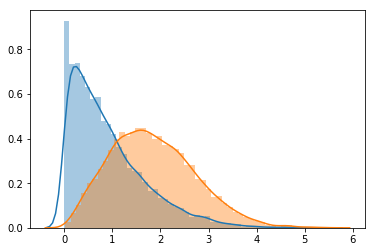

In [20]:
sns.distplot(samples_1np)
sns.distplot(samples_2np)